# SDCA

On commence par mettre en place un algorithme SDCA classique

### Génération des données

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from prettytable import PrettyTable

np.random.seed(0)

n_samples, n_features = 1000, 10
X = np.random.randn(n_features, n_samples)
w_real = np.random.randn(n_features)
y = np.sign(np.dot(X.T,w_real) + np.random.randn(n_samples))

### Définition des fonctions de perte

> On introduit un wrapper, au cas où l'on souhaite tester d'autres fonctions de perte

In [3]:
class LossFunc:
    
    def __init__(self):
        self.primal = None
        self.dual = None
        self.sdca_update = None
        self.sgd_update = None
        self.pegasos_batch_update = None
    
    def set_primal(self, func):
        self.primal = func
    
    def set_dual(self, func):
        self.dual = func
    
    def set_sdca_update(self, func):
        self.sdca_update = func
    
    def set_sgd_update(self, func):
        self.sgd_update = func
    
    def set_pegasos_batch_update(self, func):
        self.pegasos_batch_update = func

#### Hinge loss

On applique le wrapper à la hinge loss

In [101]:
# Perte primale
def hinge_loss(a, y):
    """
        y: label
        a: prediction
    """
    return np.maximum(0, 1 - y * a)

# Duale
def hinge_dual(u, y):
    """
        y: label
        u: prediction
    """
    prod = u * y
    prod[prod > 0] = np.inf
    prod[prod < -1] = np.inf
    return prod

# Update de alpha
def hinge_update(y, w, x, n, lamb, alpha, gamma=0):
    # p.577 du papier
    """
        Update alpha pour la hinge loss
        y: label
        w: poids actuels
        x: inputs
        n: nombre de samples
        lamb: step
        alpha: variable du dual (reel)
        gamma: smoothness
    """
    n=x.shape[0]
    minim = min(1, ((1-np.dot(x.T,w)*y)*n*lamb/(np.power(np.linalg.norm(x), 2))+alpha*y))
    delta_alpha = y* max(0, minim)-alpha
    return (delta_alpha) 

hinge = LossFunc()
hinge.set_primal(hinge_loss)
hinge.set_dual(hinge_dual)
hinge.set_sdca_update(hinge_update)

#### Smoothed hinge loss

In [102]:
# On définit la fonction qui update alpha pour la hinge loss
    
    
# On définit la fonction qui update alpha pour la absolute deviation loss 
def update_absolute_deviation_loss(y, w, x, n, lamb, alpha, gamma=0):
    """
        Update alpha pour la absolute deviation loss
        y: label
        w: poids actuels
        x: inputs
        n: nombre de samples
        lamb: step
        alpha: variable du dual
        gamma: smoothness
    """
    minim = min(1, ((y-np.dot(x.T,w))/(np.power(np.linalg.norm(x), 2)/(lamb*n)))+alpha)
    delta_alpha = max(-1, minim)-alpha
    return (delta_alpha)

# On définit la fonction qui update alpha pour la smooth hinge loss 
def update_smoothed_hinge_loss(y, w, x, n, lamb, alpha, gamma):
    """
        Update alpha pour la smoothed hinge loss 
        y: label
        w: poids actuels
        x: inputs
        n: nombre de samples
        lamb: step
        alpha: variable du dual
        gamma: smoothness
    """
    minim = min(1, ((1-np.dot(x.T,w)*y-gamma*alpha*y)/(np.power(np.linalg.norm(x), 2/(lamb*n+gamma)))+alpha*y)
    delta_alpha = y*max(0, minim)-alpha
    return (delta_alpha)

SyntaxError: invalid syntax (<ipython-input-102-73140c78bcb6>, line 33)

### Définition de l'algorithme

#### Fonctions intermédiaires

On commence par mettre en place plusieurs fonctions qui vont nous être utiles dans l'algorithme

In [103]:
def w_from_alpha(alpha, X, lamb):
    """
        Obtenir les poids w du primal a partir de alpha
        alpha: vecteur de poids dans le dual
        X: variables explicatives
        lamb: regularisation
    """
    n = X.shape[1]
    return (1 / (n * lamb)) * np.dot(X,alpha)

In [104]:
# La def est p.573 du papier
def cum_loss_primal(w, X, y, lamb, lossfunction):
    """
        Calculer la loss primale cumulee (inclut penalisation)
        w: vecteur de poids dans le primal
        X: variables explicatives
        y: label a predire
        lamb: regularisation
        lossfunction: choix du type de perte
    """
    cumloss = np.mean(lossfunction.primal(np.dot(X.T,w), y))
    penal = (lamb / 2) * np.power(np.linalg.norm(w), 2)
    return cumloss + penal

In [105]:
# La def est p.573 du papier
def cum_loss_dual(alpha, X, y, lamb, lossfunction):
    """
        Calculer la loss duale cumulee (inclut penalisation)
        alpha: vecteur de poids dans le dual
        X: variables explicatives
        y: label a predire
        lamb: regularisation
        lossfunction: choix du type de perte
    """   
    # On doit d'abord extraire w de alpha
    w = w_from_alpha(alpha, X, lamb)
    cumloss = np.mean(- lossfunction.dual(- alpha, y))
    penal = -(lamb / 2) * np.power(np.linalg.norm(w), 2)
    return cumloss + penal

In [106]:
def duality_gap(alpha, X, y, lamb, lossfunction):
    """
        Calcule le duality gap (diff des loss)
        alpha: vecteur de poids dans le dual
        X: variables explicatives
        y: label a predire
        lamb: regularisation
    """
    # On doit d'abord extraire w de alpha
    w = w_from_alpha(alpha, X, lamb)
    primal = cum_loss_primal(w, X, y, lamb, lossfunction)
    dual = cum_loss_dual(alpha, X, y, lamb, lossfunction)
    return primal - dual

#### Algorithme

On passe ensuite a l'algorithme a proprement parler

In [145]:
def SDCA (X, y, T, lossfunction, gamma, T_0_ratio, epsilon =1e-3, lamb = 1e-5):
    """
        Algorithme SDCA classique
        X: variables explicatives
        y: label a predire
        T: nombre d'epoch
        lossfunction: choix de la loss function
        gamma: parametre de smoothing, 1 etant tres smooth
        T_0_ratio: fraction qui indique quelle part des iterations on conserve
                    pour moyenner et obtenir alpha et w finaux
        lamb: regularisation
    """
    n_samples = X.shape[1]
    n_features=X.shape[0]
    Alpha=[]
    alpha= [0] * n_samples
    Alpha.append(alpha.copy())
    
    # On enregistre la primal loss
    primal_loss_track = []
    w = w_from_alpha(alpha, X, lamb)
    primal_loss_track.append(cum_loss_primal(w, X, y, lamb, lossfunction))
    
    # On enregistre la dual loss
    dual_loss_track = []
    dual_loss_track.append(cum_loss_dual(np.array(Alpha[0]), X, y, lamb, lossfunction))
    
    # On enregistre le duality gap
    gaps_track = []
    gap = duality_gap(np.array(Alpha[0]), X, y, lamb, lossfunction)
    gaps_track.append(gap)

    t = 0
    timelaps = [0]
    dual_loss=epsilon+1
    
    
    while (gap > epsilon) and (t < T) :
        start = time.perf_counter()
        indices = np.array(range(0, n_samples))
        np.random.shuffle(indices)
        for i in range(0, n_samples):
            j = indices[i]
            delta_alpha = lossfunction.sdca_update(y[j], w, X[:,j], n_samples, lamb, alpha[j], gamma)
            alpha[j] += delta_alpha
            w += (1 / (lamb * n_samples)) * delta_alpha * X[:,j]
        end = time.perf_counter()
        timelaps.append(end - start)
        #A la fin de chaque epoch, on enregistre
        # alpha
        Alpha.append(alpha.copy())
        # la primal loss
        primal_loss_track.append(cum_loss_primal(w, X, y, lamb, lossfunction))
        # la dual loss
        dual_loss=cum_loss_dual(np.array(alpha), X, y, lamb, lossfunction)
        dual_loss_track.append(cum_loss_dual(np.array(alpha), X, y, lamb, lossfunction))
        # le duality gap
        gap = duality_gap(np.array(alpha), X, y, lamb, lossfunction)
        gaps_track.append(gap)
        t += 1

    # Une fois que l'algorithme a converge, on recupere les weights a partir de la matrice alpha
    alpha_bar = np.mean(Alpha[-int(T_0_ratio*T):],axis=0)
    w_bar = w_from_alpha(alpha_bar,X, lamb)
    
    # Sortie aleatoire
    k = np.random.randint(int(T_0_ratio*T),T-2)
    alpha_rand = Alpha[k]
    w_rand=w_from_alpha(alpha_rand, X, lamb)
    
    return(Alpha, timelaps, primal_loss_track, dual_loss_track, gaps_track, w_bar, w_rand)

### Résultats pour les données simulées

In [146]:
[Alpha, timelaps, primal_loss_track, dual_loss_track, gaps_track, w_bar, w_rand]=SDCA(X, y, 20, hinge, 1.0 , 1/2, 1e-3, 1e-1)

On compare les poids obtenus par la méthode de la moyenne et celle du choix aléatoire aux vrais poids

In [147]:
w = PrettyTable()
w.add_column("poids initiaux",w_real)
w.add_column("poids obtenus par moyenne",w_bar)
w.add_column("poids obtenus par alea",w_rand)
print (w)

+-----------------+---------------------------+------------------------+
|  poids initiaux | poids obtenus par moyenne | poids obtenus par alea |
+-----------------+---------------------------+------------------------+
| -0.202117027136 |      -0.122213904959      |    -0.119798457071     |
| -0.833231000673 |      -0.420864175527      |    -0.432318470184     |
|  1.73360024744  |       0.739662892121      |     0.75237813271      |
|  0.190649004077 |       0.100195818939      |     0.102605129075     |
| -0.177810393649 |      -0.0129899083358     |    -0.0146288308927    |
|  -1.08502511902 |      -0.440902499232      |    -0.448849180301     |
|  0.972262332841 |       0.472231826285      |     0.483701099306     |
|  1.43147168404  |       0.685477937431      |     0.692971923132     |
| -0.245073043259 |      -0.137539248591      |    -0.147132164746     |
| -0.623253810112 |       -0.30355049432      |    -0.315020137865     |
+-----------------+---------------------------+----

On regarde l'évolution de la perte primale et du duality gap

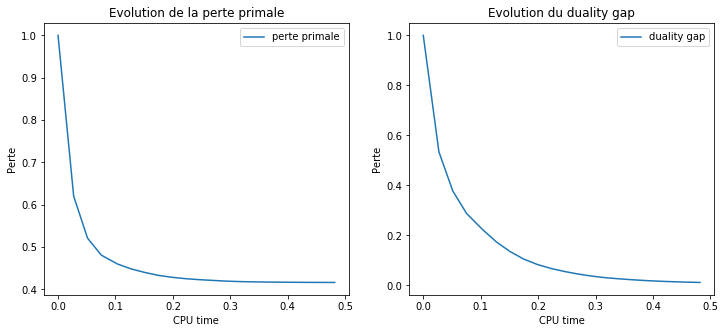

In [148]:
plt.figure(figsize=(12,5))
plt.plot([2,1])
plt.subplot(121)
plt.plot(np.cumsum(timelaps), primal_loss_track , label="perte primale")
plt.ylabel("Perte")
plt.xlabel("CPU time")
plt.legend()
plt.title("Evolution de la perte primale")

plt.subplot(122)
plt.plot(np.cumsum(timelaps), gaps_track , label="duality gap")
plt.ylabel("Perte")
plt.xlabel("CPU time")
plt.legend()
plt.title("Evolution du duality gap")
plt.show()

### On introduit une Stochastic Gradient Descent pour la premiere epoch

##### Cas du primal avec hinge loss

On appelle $S$ un ensemble de points, $x_i \in \mathbb{R}^{n}$ et les labels correspondants, $y_i \in \{−1,1\}$. On cherche un hyperplan qui minimiserait la hinge loss totale.

\begin{equation}
w^* = \underset{w}{\text{argmin }} L^{hinge}_S(w) = \underset{w}{\text{argmin }} \sum_i{l_{hinge}(w,x_i,y_i)}= \underset{w}{\text{argmin }} \sum_i{\max{\{0,1-y_iw\cdot x_i}\}}
\end{equation}

On identifie le gradient:

$$\frac{\partial{l_{hinge}}}{\partial w}=
\begin{cases}
  0  & y_iw\cdot x_i \geq 1 \\
  -y_ix & y_iw\cdot x_i < 1
\end{cases}$$

On obtient alors l'update suivant

$$w^{t+1}=\left(1-\frac{1}{t}\right)w^{t} - \frac{1|(y_i w^{t}\cdot x_i)}{\lambda t}x_i$$

##### Cas du dual avec hinge loss

Soit $t \in \{1,...,n\}$


Puisque pour la *Stochastic Gradient Descent*, on update selon une seule observation $t$ à chaque fois, l'objectif est de choisir le réel $\alpha_t$ qui maximise : 
$$ - \frac{1}{n} \phi_t^{\star}(-\alpha_t) - \frac{\lambda}{2} ||w^{t}||^2$$
Or, on a:
$$ \begin{align}
w^{t} = &  w^{t-1} + \Delta w\\
 = & w^{t-1} + \frac{1}{\lambda n}\sum_{i = 1}^{n} \Delta \alpha _{i} x_i\\
 = & w^{t-1} + \frac{1}{\lambda n} \Delta \alpha _{t} x_t \\
 = & w^{t-1} + \frac{1}{\lambda n} \alpha _{t} x_t \\
\end{align}$$
En effet, $\alpha_t$ est initialisé à 0 et le SGD sert à la première epoch seulement. On se retrouve donc à maximiser:

$$ - \phi_t^{\star}(-\alpha_t) - \frac{\lambda n}{2} ||w^{t-1} + \frac{1}{\lambda n} \alpha _{t} x_t ||^2$$

En développant : 
$$ \alpha_t y_t - \frac{\lambda n}{2} \left( ||w^{t-1}||^2 + 2 \frac{\alpha_t}{\lambda n} \langle w^{t-1}, x_t \rangle + \frac{\alpha_t^2}{\lambda^2 n^2}||x_t||^2 \right)$$

L'expression est concave du fait du terme de second ordre négatif. L'extremum sera donc un maximum. On applique la formule du maximizer dans un polynome de degré 2:
$$ \alpha_t= \frac{\lambda n}{||x_t||^2} \left(y_t - x_t^T w^{t-1}\right)$$

On peut donc adapter l'algorithme pour qu'il incorpore un SGD pour la première epoch.

On commence par compléter le wrapper

In [311]:
def hinge_sgd_update(y, w, x, t, lamb):
    return ((lamb * t) /  (np.linalg.norm(x)**2)) * (y - np.dot(x.T, w))

hinge.set_sgd_update(hinge_sgd_update)

In [303]:
def modified_sgd(xmat, y, lamb, lossfunc=hinge):
    d = xmat.shape[0]
    n = xmat.shape[1]
    alpha = np.zeros((n, ))
    w = np.zeros((d, ))
    for t in range(0, n):
        alpha[t] = lossfunc.sgd_update(w, xmat[:, t], y[t], lamb, t)
        w = alpha_to_w(alpha[:t + 1], xmat[:, :t + 1], lamb)
    return alpha, w       

In [312]:
def SDCA (X, y, T, lossfunction, gamma, T_0_ratio, epsilon =1e-3, lamb = 1e-5, SGD_init=True):
    """
        Algorithme SDCA classique
        X: variables explicatives
        y: label a prdire
        T: nombre d'epoch
        lossfunction: choix de la loss function
        gamma: parametre de smoothing, 1 etant tres smooth
        T_0_ratio: fraction qui indique quelle part des iterations on conserve
                    pour moyenner et obtenir alpha et w finaux
        lamb: regularisation
        SGD_init: initialisation premiere epoch par SGD
    """
    n_samples = X.shape[1]
    n_features=X.shape[0]
    Alpha=[]
    alpha= [0] * n_samples
    Alpha.append(alpha.copy())
    
    # On enregistre la primal loss
    primal_loss_track = []
    w = w_from_alpha(alpha, X, lamb)
    primal_loss_track.append(cum_loss_primal(w, X, y, lamb, lossfunction))
    
    # On enregistre le duality gap
    gaps_track = []
    gap = duality_gap(np.array(Alpha[0]), X, y, lamb, lossfunction)
    gaps_track.append(gap)

    t = 0
    timelaps = [0]
    
    # Puis la boucle normale
    while (gap > epsilon) and (t < T) :
        start = time.perf_counter()
        indices = np.array(range(0, n_samples))
        np.random.shuffle(indices)
        for i in range(0, n_samples):
            j = indices[i]
            
            # Initialisation eventuelle SGD
            #if (t==0) and (SGD_init==True):
            if (t==0):
                alpha[i] = lossfunction.sgd_update(y[i], w, X[:, i], i, lamb)
                w=w_from_alpha(alpha[:i+1], X[:,:i+1], lamb)
                
                
            # Sinon SDCA standard
            else:
                delta_alpha = lossfunction.sdca_update(y[j], w, X[:,j], n_samples, lamb, alpha[j], gamma)
                alpha[j] += delta_alpha
                w += (1 / (lamb * n_samples)) * delta_alpha * X[:,j]
        
        print(alpha)
        end = time.perf_counter()
        timelaps.append(end - start)
        #A la fin de chaque epoch, on enregistre
        # alph
        Alpha.append(alpha.copy())
        # la primal loss
        primal_loss_track.append(cum_loss_primal(w, X, y, lamb, lossfunction))
        # le duality gap
        gap = duality_gap(np.array(alpha), X, y, lamb, lossfunction)
        gaps_track.append(gap)
        t += 1

    # Une fois que l'algorithme a converge, on recupere les weights a partir de la matrice alpha
    alpha_bar = np.mean(Alpha[-int(T_0_ratio*T):],axis=0)
    w_bar = w_from_alpha(alpha_bar,X, lamb)
    
    # Sortie aleatoire
    k = np.random.random_integers(int(T_0_ratio*T),T-2)
    #alpha_rand = Alpha[k]
    #w_rand=w_from_alpha(alpha_rand, X, lamb)
    w_rand=1
    
    return(Alpha, timelaps, primal_loss_track, gaps_track, w_bar, w_rand)

In [313]:
[Alpha, timelaps, primal_loss_track, gaps_track, w_bar, w_rand]=SDCA(X, y, 20, hinge, 1.0 , 1/2, 1e-3, 1e-1, False)

[-0.0, -0.01059485683501594, 0.02401167614313891, -0.03412951342742457, 0.019304405003268067, 0.0650752074929264, -0.013214716262949386, -0.07918297941308165, -0.0945005057592715, 0.03606811395469187, -0.16160283910130208, -0.020627110272739203, 0.0419476060622714, -0.006518917504865724, -0.13558233791052626, -0.1251635145739156, -0.13976222835280178, 0.3474508560989361, -0.11577037636297988, 0.1856604166717156, -0.0714457280623061, 0.08423582736108116, 0.14013383053259476, -0.0823849620947388, -0.01611447664896798, 0.27266848705616314, -0.02549389818070347, 0.4881480195129931, 0.2840878050143848, -0.2900281739200022, 0.1437952391518163, -0.284224586245728, -0.19158290781909418, -0.01520909740287402, -0.021158351127978387, -0.6649575471732321, -0.4838715941993768, 0.2678368120208035, -0.2379404568724391, 0.049520458414861926, -0.34292119820971095, 0.16957499663020073, 0.3223097140707824, 0.16824033514635667, 0.4378167522679415, -0.1825658805929297, -1.1243248098288925, -0.2210977801043

[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, -0.5156719315961287, 0.0, -0.056057486927678216, 1.0, 0.0, 0.0, -1.0, 0.0, -0.5206292927923882, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4918598893078395, 0.0, 0.60877558249589, 0.5809222789545494, -0.6709569914067648, 0.0, -0.5731244672127326, 0.0, 0.0, 0.0, -0.919043558211256, -0.4761839094495422, 0.06089765984863474, 0.0, 0.5305173280566267, 0.0, 0.5029820700159748, 0.7154262637065469, 0.0, 0.457012374839691, 0.0, -1.0, 0.0, 1.0, 0.0, -0.26915214074012184, 0.5191649326733987, 0.0, 0.7413435774142546, 0.0, 0.0, -0.044428291178428655, 0.0, 1.0, 0.6343479655539304, 0.9697940876389968, 0.0, 1.0, -0.5157426027542698, -0.17740985841691756, 0.7647005778028512, -1.0, 0.0, -0.38839052938535845, -1.0, 1.0, 1.0, 1.0, -1.0, 0.0, 1.0, 1.0, -0.8860187705399728, 0.8344152230701768, 0.41471187110308494, 0.0, 0.0, -0.575117886746293, 0.0, -1.0, 0.003160534383760759, -1.0, 0.0, 0.0, 0.0, 0.4292765760613634, 0.5721243338285628, 0.5438234652337388, 0.8415204436

[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, -0.9306714984886117, 0.0, -0.40230342634488825, 1.0, 0.0, 0.001967173212915338, -1.0, -0.014917187977002703, -0.8731051325345779, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9083606311193834, 0.0, 0.8198823868705392, 0.9763708274289958, -0.8653737536620694, 0.0, -0.7115061885796957, 0.0, 0.0, 0.0, -1.0, -0.5844705332497234, 0.057214607659315644, -0.000977050076273555, 0.8305922564142867, 0.0, 0.7443288638830332, 1.0, 0.0, 0.5719064956137475, 0.0, -1.0, 0.0, 1.0, 0.0, -0.32855453302495025, 1.0, 0.0, 1.0, 0.0, 0.0, -0.27644405444990017, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, -0.43557347315532385, -0.44135582196560436, 1.0, -1.0, 0.0, -0.8219800678936142, -1.0, 1.0, 1.0, 1.0, -1.0, 0.0, 1.0, 1.0, -1.0, 0.8607017802957385, 0.9718051276348245, 0.0, 0.0, -0.6818515924876479, 0.0, -1.0, 0.04097672038393464, -1.0, 0.0, 0.0, 0.0, 0.2543005957916503, 0.6690260398887534, 0.6673150370986295, 1.0, 0.39761747049760016, 0.0, 0.0, 0.0, -0.31553072220011286, 1.0, -0.321252

[0.0, 0.0, 1.0, 0.0, 0.0008985297204436579, 1.0, 0.0, 0.0, -1.0, 0.0, -0.7776436769554801, 1.0, 0.0, 0.02604052017967727, -1.0, -0.05458797404531392, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, -1.0, 0.0, -0.9110320804738972, 0.0, 0.0, 0.0, -1.0, -0.6956795060002889, 0.05876858713326189, -0.01778874751917454, 1.0, 0.0, 0.9912184720762458, 1.0, 0.0, 0.6971173999558855, 0.0, -1.0, 0.0, 1.0, 0.0, -0.39290935543057004, 1.0, 0.0, 1.0, 0.0, 0.0, -0.5462450687045297, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, -0.3712892984433489, -0.6845789798374158, 1.0, -1.0, 0.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 0.0, 1.0, 1.0, -1.0, 0.9085507402372928, 1.0, 0.0, 0.0, -0.7741967852580052, 0.0, -1.0, 0.09033408192559002, -1.0, 0.0, 0.0, 0.0, 0.09055761832048981, 0.7868342172540073, 0.7693519846182426, 1.0, 0.5373790425392423, 0.0, 0.0, 0.0, -0.28474185315223144, 1.0, -0.40758510741883275, 0.0, -1.0, 0.5265417208833361, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.4156833052665454, 0.9133017635619294, 0

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: This function is deprecated. Please call randint(10, 18 + 1) instead


In [314]:
gaps_track

[1.0,
 inf,
 0.6001275786888927,
 0.2958407195445291,
 0.16669487866444638,
 0.10440293426002478,
 0.07564217956954189,
 0.05963743680323946,
 0.049836134423569156,
 0.04294779257616366,
 0.037686737906202084,
 0.03346201379996622,
 0.029645393756881466,
 0.026373373654545562,
 0.023685273734403656,
 0.0213775262837968,
 0.01939355502472523,
 0.017693690648391547,
 0.01624099504309623,
 0.014943103774046618,
 0.01377303395268814]

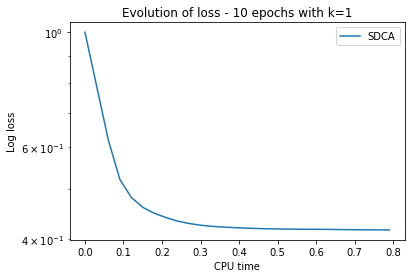

In [244]:
plt.semilogy(np.cumsum(timelaps), primal_loss_track, label="SDCA")
#plt.semilogy(np.cumsum(perfs_pegasos), losses_pegasos, label="Pegasos")
plt.ylabel("Log loss")
plt.xlabel("CPU time")
plt.legend()
plt.title("Evolution of loss - 10 epochs with k=1")
plt.show()

Work in PROGRESS

In [ ]:
def hinge_loss(w,X,y):
    """ 
    Evalue la hinge loss et son gradient en w
    w: poids actuels
    X: matrice des inputs
    y: vecteur des labels
    """
    loss,grad = 0,0
    for (X_,y_) in zip(X,y):
        v = y_*np.dot(w,X_)
        loss += max(0,1-v)
        grad += 0 if v >= 1 else -y_*x_
    return (loss,grad)

def grad_descent(X,y,w,step,thresh=0.0001):
    grad = np.inf
    ws = np.zeros((3,0))
    ws = np.hstack((ws,w.reshape(3,1)))
    step_num = 1
    delta = np.inf
    loss0 = np.inf
    while np.abs(delta)>thresh:
        loss,grad = hinge_loss(w,X,y)
        delta = loss0-loss
        loss0 = loss
        grad_dir = grad/np.linalg.norm(grad)
        # On a un stepsize qui decroit avec le nb d'iterations
        w = w-(step/step_num)*grad_dir
        ws = np.hstack((ws,w.reshape((3,1))))
        step_num += 1
    return np.sum(ws,1)/np.size(ws,1)

def test1():
    # sample data points
    x1 = np.array((0,1,3,4,1))
    x2 = np.array((1,2,0,1,1))
    x3 = np.array((2,0,3,1,0))
    x  = np.vstack((x1,x2,x3)).T
    # sample labels
    y = np.array((1,1,-1,-1,-1))
    w = grad_descent(x,y,np.array((0,0,0)),0.1)
    loss, grad = hinge_loss(w,x,y)
    return(loss)
    #plot_test(x,y,w)

def plot_test(x,y,w):
    plt.figure()
    x1, x2 = x[:,0], x[:,1]
    x1_min, x1_max = np.min(x1)*.7, np.max(x1)*1.3
    x2_min, x2_max = np.min(x2)*.7, np.max(x2)*1.3
    gridpoints = 2000
    x1s = np.linspace(x1_min, x1_max, gridpoints)
    x2s = np.linspace(x2_min, x2_max, gridpoints)
    gridx1, gridx2 = np.meshgrid(x1s,x2s)
    grid_pts = np.c_[gridx1.ravel(), gridx2.ravel()]
    predictions = np.array([np.sign(np.dot(w,x_)) for x_ in grid_pts]).reshape((gridpoints,gridpoints))
    plt.contourf(gridx1, gridx2, predictions, cmap=plt.cm.Paired)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.Paired)
    plt.title('total hinge loss: %g' % hinge_loss(w,x,y)[0])
    plt.show()

if __name__ == '__main__':
    np.set_printoptions(precision=3)
    test1()

In [ ]:
test1()

In [ ]:
w=np.array((1,3,2))
ws = np.zeros((3,0))
ws = np.hstack((ws,w.reshape(3,1)))

In [ ]:
ws